In [386]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

## 1. Preparing data and plot functions

In [387]:
df_data = pd.read_csv('../data/train.csv')
df_data.head(1)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.0,0.00293,0.00293,0.035156,0.0,0.0,0.004883,0.0,0.025391


In [388]:
X = ((df_data.iloc[:,2:] - df_data.iloc[:,2:].min()) / (df_data.iloc[:,2:].max() - df_data.iloc[:,2:].min())).values

species = df_data['species'].unique()

# Creation of one-hot vectors for the target matrix
t = np.zeros(df_data.shape[0])
for i in range(species.size):
    t[df_data['species'] == species[i]] = i

In [389]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=0)

In [390]:
#Creation of lists of possible hyper-parameter values
big_C = np.arange(1,111,10)
small_C = np.arange(1,11,1) 
all_values_Gamma = np.logspace(-9, 0, 10)
all_values_Degree = [2,3,4,5,6,7,8,9,10]

In [391]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2, axis):
    # grid_param_1 is the first parameter to vary
    # grid_param_2 is the second parameter to vary
    
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2), len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1, figsize = (8,6))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    if axis == 0:
        for idx, val in enumerate(grid_param_1):
            ax.semilogx(grid_param_2, scores_mean[:,idx], '-o', label= name_param_1 + ': ' + str(val))
            ax.set_xlabel(name_param_2, fontsize=10)
    elif axis == 1:
        for idx, val in enumerate(grid_param_2):
            ax.semilogx(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
            ax.set_xlabel(name_param_1, fontsize=10)
    else:
        print("unknown axis")
    
    ax.set_title("Grid Search Scores", fontsize=10, fontweight='bold')
    ax.set_ylabel('CV Average Score', fontsize=10)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
    ax.grid('on') 

In [392]:
def plot_grid_search_single_param(cv_results, grid_param, name_param, figsize=(10, 6)):
    # Get Test Scores Mean for each grid search
    scores_mean = cv_results['mean_test_score']

    # Plot the 2D curve
    plt.figure(figsize=figsize)
    plt.plot(grid_param, scores_mean, '-o')

    # Add labels and a title
    plt.xlabel(name_param)
    plt.ylabel('CV Average Score')
    plt.title("Grid Search Scores", fontsize=12, fontweight='bold')
    
    plt.grid(True)
    plt.show()

## 2. SVM linear kernel
### 2.1 Without optimisation

In [393]:
classifieur_linear = svm.SVC(kernel='linear')
classifieur_linear.fit(X_train, t_train)

SVC(kernel='linear')

In [394]:
print("Accuracy X_train, t_train : {:.2f}%".format(classifieur_linear.score(X_train, t_train)*100))
print("Accuracy X_test, t_test : {:.2f}%".format(classifieur_linear.score(X_test, t_test)*100))

Score X_train, t_train : 100.00%
Score X_test, t_test : 98.32%


### 2.2 Optimization of hyper-parameter

In [395]:
#Parameter to be tested
param_grid_svm_linear= {
    'C' : small_C
}

# Creation of the grid search model
grid_search_svm_linear = GridSearchCV(svm.SVC(kernel='linear'), param_grid_svm_linear, cv=3, verbose=3, n_jobs=-1)

# Training the model with grid search
grid_search_svm_linear.fit(X_train, t_train)
print('Done')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Done


In [396]:
results_grid_svm_linear = pd.DataFrame.from_dict(grid_search_svm_linear.cv_results_)

In [397]:
print("Best parameter:", grid_search_svm_linear.best_params_)
print("Best accuracy on a split :  : {:.2f}%".format(grid_search_svm_linear.best_score_*100))
print("Accuracy X_train, t_train : {:.2f}%".format(grid_search_svm_linear.score(X_train, t_train)*100))
print("Accuracy X_test, t_test : {:.2f}%".format(grid_search_svm_linear.score(X_test, t_test)*100))

Best parameter: {'C': 2}
Best score on a split :  : 98.27%
Score X_train, t_train : 100.00%
Score X_test, t_test : 98.32%


### 2.3 Visualisation of the evolution of our accuracy according to the evolution of our hyper-parameters

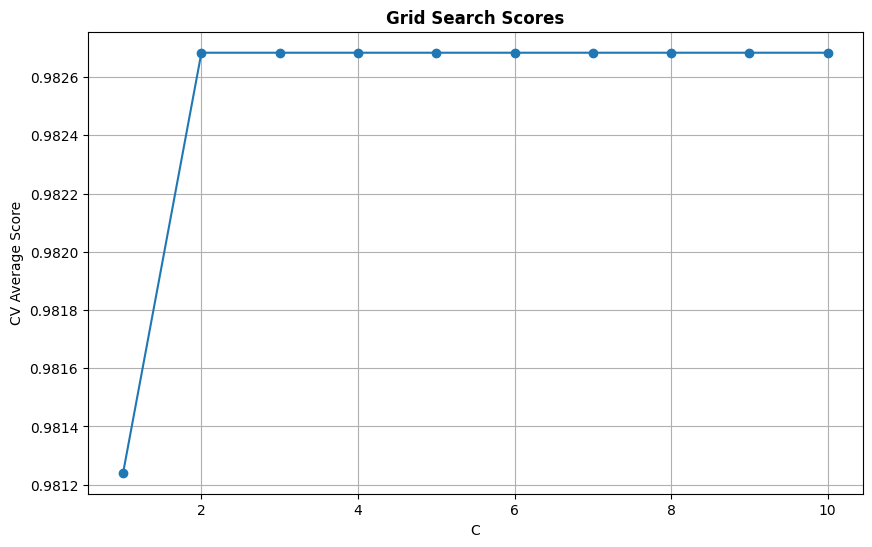

In [398]:
plot_grid_search_single_param(results_grid_svm_linear, small_C, 'C')

## 3. SVM kernel RBF
### 3.1 Without optimization

In [399]:
classifieur_rbf = svm.SVC(kernel='rbf',gamma=0.7) 
classifieur_rbf.fit(X_train, t_train)

SVC(gamma=0.7)

In [400]:
print("Accuracy X_train, t_train : {:.2f}%".format(classifieur_rbf.score(X_train, t_train)*100))
print("Accuracy X_test, t_test : {:.2f}%".format(classifieur_rbf.score(X_test, t_test)*100))

Score X_train, t_train : 100.00%
Score X_test, t_test : 94.61%


### 3.2 Optimization of hyper-parameters

In [401]:
# Parameters to be tested
param_grid_svm_rbf= {
    'gamma' : all_values_Gamma,
    'C' : big_C,
}

# Creation of the grid search model
grid_search_svm_rbf = GridSearchCV(svm.SVC(kernel='rbf'), param_grid_svm_rbf, cv=3, verbose=3, n_jobs=-1)

# Training the model with grid search
grid_search_svm_rbf.fit(X_train, t_train)
print('Done')

Fitting 3 folds for each of 110 candidates, totalling 330 fits
Done


In [402]:
results_grid_svm_rbf = pd.DataFrame.from_dict(grid_search_svm_rbf.cv_results_)

In [403]:
print("Best parameters :", grid_search_svm_rbf.best_params_)
print("Best accuracy on a split : {:.2f}%".format(grid_search_svm_rbf.best_score_*100))
print("Accuracy X_train, t_train : {:.2f}%".format(grid_search_svm_rbf.score(X_train, t_train)*100))
print("Accuracy X_test, t_test : {:.2f}%".format(grid_search_svm_rbf.score(X_test, t_test)*100))

Best parameters : {'C': 61, 'gamma': 0.01}
Best score on a split : 98.41%
Score X_train, t_train : 100.00%
Score X_test, t_test : 98.32%


### 3.3 Visualization of the evolution of our accuracy according to the evolution of our hyper-parameters

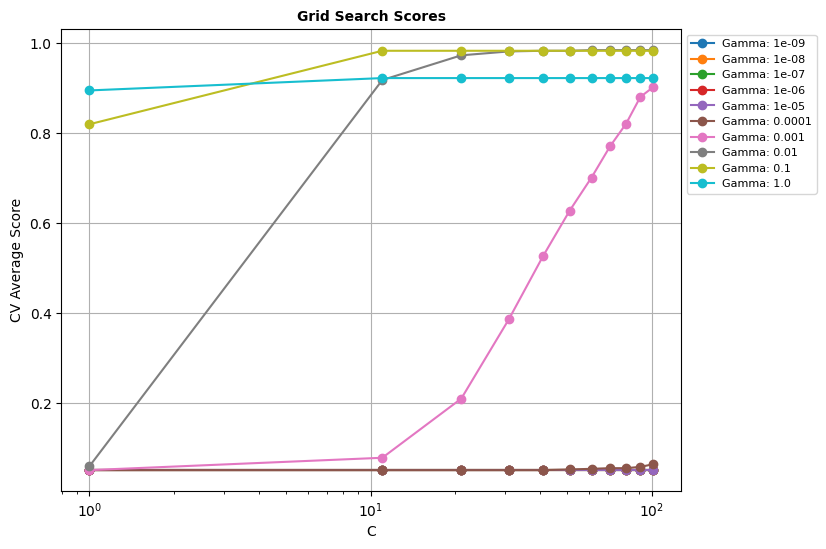

In [404]:
plot_grid_search(results_grid_svm_rbf, all_values_Gamma,big_C, 'Gamma','C', axis=0)

## 4. SVM polynomial kernel
### 4.1 Without optimization

In [405]:
classifieur_poly = svm.SVC(kernel='poly', degree=2, gamma="auto")
classifieur_poly.fit(X_train, t_train)

SVC(degree=2, gamma='auto', kernel='poly')

In [406]:
print("Accuracy X_train, t_train : {:.2f}%".format(classifieur_poly.score(X_train, t_train)*100))
print("Accuracy X_test, t_test : {:.2f}%".format(classifieur_poly.score(X_test, t_test)*100))

Score X_train, t_train : 8.51%
Score X_test, t_test : 0.00%


### 4.2 Optimization of hyper-parameters

In [407]:
# Parameters to be tested
param_grid_svm_poly= {
    'C' : big_C,
    'degree' : all_values_Degree
}

# Creation of the grid search model
grid_search_svm_poly = GridSearchCV(svm.SVC(kernel="poly", gamma='auto'), param_grid_svm_poly, cv=3, verbose=3, n_jobs=-1)

# Training the model with grid search
grid_search_svm_poly.fit(X_train, t_train)
print('Done')

Fitting 3 folds for each of 99 candidates, totalling 297 fits
Done


In [408]:
results_grid_svm_poly = pd.DataFrame.from_dict(grid_search_svm_poly.cv_results_)

In [409]:
print("Best parameters :", grid_search_svm_poly.best_params_)
print("Best accuracy on a split : {:.2f}%".format(grid_search_svm_poly.best_score_*100))
print("Accuracy X_train, t_train : {:.2f}%".format(grid_search_svm_poly.score(X_train, t_train)*100))
print("Accuracy X_test, t_test : {:.2f}%".format(grid_search_svm_poly.score(X_test, t_test)*100))

Best parameters : {'C': 101, 'degree': 2}
Best score on a split : 26.12%
Score X_train, t_train : 40.98%
Score X_test, t_test : 22.22%


### 4.3 Visualization of the evolution of our accuracy according to the evolution of our hyper-parameters

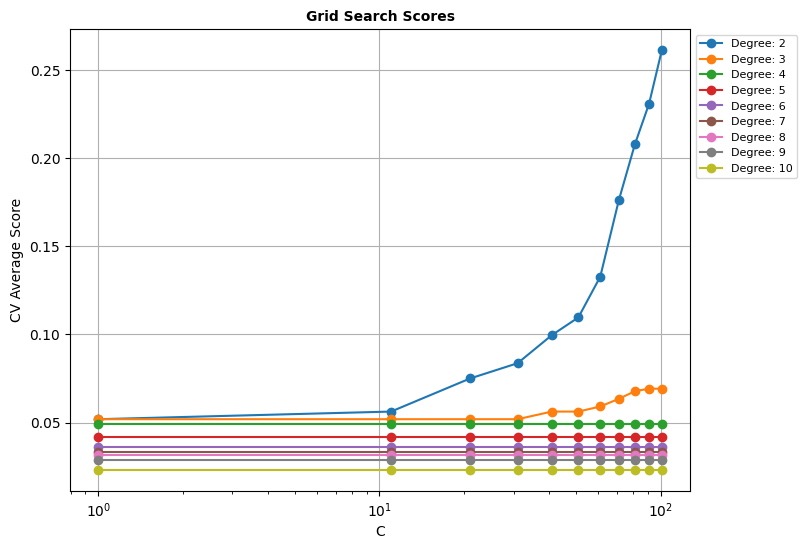

In [410]:
plot_grid_search(results_grid_svm_poly, all_values_Degree,big_C,'Degree', 'C', axis=0)

## 5. SVM Noyau Simoidal
### 5.1 Without optimization

In [411]:
classifieur_sigmoid = svm.SVC(kernel='sigmoid', gamma=0.7)
classifieur_sigmoid.fit(X_train, t_train)

SVC(gamma=0.7, kernel='sigmoid')

In [412]:
print("Accuracy X_train, t_train : {:.2f}%".format(classifieur_sigmoid.score(X_train, t_train)*100))
print("Accuracy X_test, t_test : {:.2f}%".format(classifieur_sigmoid.score(X_test, t_test)*100))

Score X_train, t_train : 0.58%
Score X_test, t_test : 0.00%


### 5.2 Optimization of hyper-parameters

In [413]:
# Parameters to be tested
param_grid_svm_sigmoid= {
    'C' : big_C,
    'gamma' : all_values_Gamma
}

# Creation of the grid search model
grid_search_svm_sigmoid = GridSearchCV(svm.SVC(kernel="sigmoid"), param_grid_svm_sigmoid, cv=3, verbose=3, n_jobs=-1)

# Training the model with grid search
grid_search_svm_sigmoid.fit(X_train, t_train)
print('Done')

Fitting 3 folds for each of 110 candidates, totalling 330 fits
Done


In [414]:
results_grid_svm_sigmoid = pd.DataFrame.from_dict(grid_search_svm_sigmoid.cv_results_)

In [415]:
print("Best parameters :", grid_search_svm_sigmoid.best_params_)
print("Best accuracy on a split : {:.2f}%".format(grid_search_svm_sigmoid.best_score_*100))
print("Accuracy X_train, t_train : {:.2f}%".format(grid_search_svm_sigmoid.score(X_train, t_train)*100))
print("Accuracy X_test, t_test : {:.2f}%".format(grid_search_svm_sigmoid.score(X_test, t_test)*100))

Best parameters : {'C': 81, 'gamma': 0.01}
Best score on a split : 98.27%
Score X_train, t_train : 100.00%
Score X_test, t_test : 98.32%


### 5.3 Visualization of the evolution of our accuracy according to the evolution of our hyper-parameters

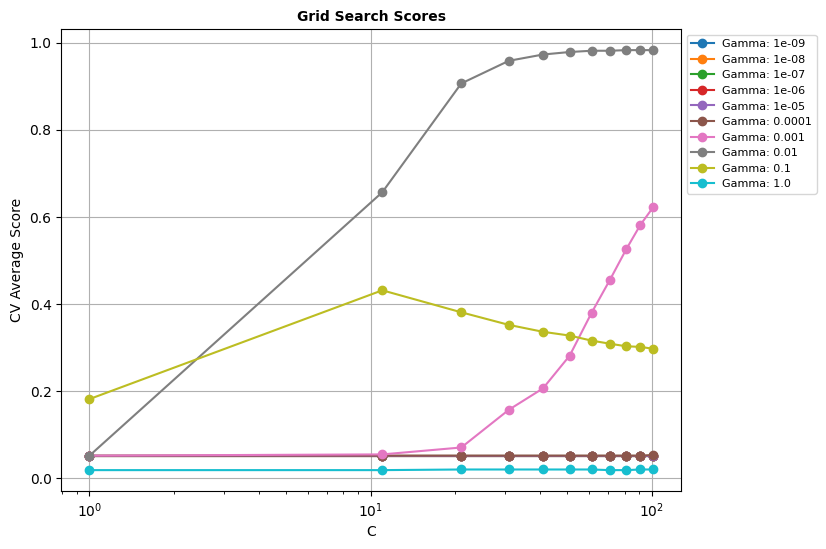

In [416]:
plot_grid_search(results_grid_svm_sigmoid, all_values_Gamma,big_C,'Gamma','C',axis=0)